In [14]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import get_context
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import json
import pprint

workspace_root = Path.cwd().parent.parent

src_path = workspace_root / "data"
if not src_path.exists():
    raise FileNotFoundError(f"Local data folder not found: {src_path}")

data_files = list(src_path.rglob("00*"))

data_files = [
    path for path in data_files
    if path.is_dir()
    and (path / "foci_mask.npy").exists()
    and (path / "nuclei_mask.npy").exists()
 ]
print(f"Using local data: {src_path}")
print(len(data_files))

Using local data: /Users/pszyc/Code/Science/OgniskaNaprawcze/confocal/DeepFoci/data
676


# Loading

In [17]:
FOV_X_UM = 90.0
FOV_Y_UM = 67.2
FOV_Z_UM = 15.0

X_MIN = 4
X_MAX = 18

def resize_mask_nearest_local(mask_zyx, target_shape):
    zoom_factors = np.array(target_shape, dtype=float) / np.array(mask_zyx.shape, dtype=float)
    resized = zoom(mask_zyx, zoom=zoom_factors, order=0)
    return resized.astype(mask_zyx.dtype, copy=False)

def get_voxel_volume_um3(mask_shape_zyx):
    z_px, y_px, x_px = mask_shape_zyx
    sx_um = FOV_X_UM / float(x_px)
    sy_um = FOV_Y_UM / float(y_px)
    sz_um = FOV_Z_UM / float(z_px)
    return sx_um * sy_um * sz_um

def clean_nuclei_mask_by_size(mask, x_min=X_MIN, x_max=X_MAX):
    counts = np.bincount(mask.ravel())
    if len(counts) <= 1:
        return np.zeros_like(mask, dtype=mask.dtype)

    voxel_volume_um3 = get_voxel_volume_um3(mask.shape)

    labels = np.arange(len(counts), dtype=np.int64)
    labels_fg = labels[1:]
    counts_fg = counts[1:]

    vol_fg = counts_fg * voxel_volume_um3
    x_fg = np.cbrt(vol_fg)

    labels_keep = labels_fg[(x_fg >= x_min) & (x_fg <= x_max)]
    cleaned = np.where(np.isin(mask, labels_keep), mask, 0).astype(mask.dtype, copy=False)
    return cleaned

In [18]:

def append_foci_components_with_nucleus(channel_mask, nuclei_labels, image_info, channel_name, out_rows):
    cc_mask, n_cc = label(channel_mask, structure=np.ones((3, 3, 3), dtype=np.uint8))
    if n_cc == 0:
        return

    sizes = np.bincount(cc_mask.ravel())[1:]  # skip background
    for comp_label, comp_size in enumerate(sizes, start=1):
        comp_voxels = cc_mask == comp_label
        nuclei_ids = nuclei_labels[comp_voxels]
        nuclei_ids = nuclei_ids[nuclei_ids > 0]

        if nuclei_ids.size == 0:
            continue

        counts = np.bincount(nuclei_ids.astype(np.int64))
        best_nucleus = int(np.argmax(counts))
        best_overlap = int(counts[best_nucleus])
        majority_fraction = float(best_overlap / nuclei_ids.size)

        # strict majority rule (>50% of foci voxels)
        if majority_fraction <= 0.5:
            continue

        out_rows.append({
            "image_info": image_info,
            "channel": channel_name,
            "foci_label": int(comp_label),
            "foci_size": int(comp_size),
            "nucleus_label": best_nucleus,
        })

def process_one_data_selected(data_selected):
    rows_local = []
    nuclei_rows_local = []
    image_info = "/".join(str(data_selected).split("/")[-3:])

    # local foci: (2, Z, Y, X)
    foci_mask = np.load(data_selected / "foci_mask.npy", mmap_mode="r")

    # local nuclei already prepared as (Z, Y, X) and aligned to foci shape
    nuclei_mask = np.load(data_selected / "nuclei_mask.npy", mmap_mode="r")
    nuclei_zyx = nuclei_mask.astype(np.int32, copy=False)
    nuclei_zyx = clean_nuclei_mask_by_size(nuclei_zyx)

    nucleus_labels = np.unique(nuclei_zyx)
    nucleus_labels = nucleus_labels[nucleus_labels > 0]
    nuclei_rows_local = [
        {"image_info": image_info, "nucleus_label": int(nucleus_label)}
        for nucleus_label in nucleus_labels
    ]

    # zero out all foci outside cleaned nuclei
    inside_nuclei = nuclei_zyx > 0
    gh2ax_mask = (foci_mask[0] > 0) & inside_nuclei
    p53bp1_mask = (foci_mask[1] > 0) & inside_nuclei
    colocalized_mask = gh2ax_mask & p53bp1_mask

    append_foci_components_with_nucleus(
        gh2ax_mask, nuclei_zyx, image_info, "gH2AX", rows_local
    )
    append_foci_components_with_nucleus(
        p53bp1_mask, nuclei_zyx, image_info, "53BP1", rows_local
    )
    append_foci_components_with_nucleus(
        colocalized_mask, nuclei_zyx, image_info, "colocalized", rows_local
    )

    return rows_local, nuclei_rows_local

In [19]:

paths_to_run = data_files
max_workers = min(os.cpu_count(), 8)

print(max_workers)

rows = []
nuclei_rows = []
ctx = get_context("fork")
with ProcessPoolExecutor(max_workers=max_workers, mp_context=ctx) as executor:
    for rows_local, nuclei_rows_local in tqdm(
        executor.map(process_one_data_selected, paths_to_run),
        total=len(paths_to_run),
    ):
        rows.extend(rows_local)
        nuclei_rows.extend(nuclei_rows_local)

8


100%|██████████| 676/676 [08:46<00:00,  1.28it/s]


In [20]:
foci_df = (
    pd.DataFrame(rows)
    .sort_values(["image_info", "channel", "foci_label"])
    .reset_index(drop=True)
)
foci_df.to_csv("foci.csv", index=False)

nuclei_rows_df = (
    pd.DataFrame(nuclei_rows, columns=["image_info", "nucleus_label"])
    .drop_duplicates(["image_info", "nucleus_label"])
    .sort_values(["image_info", "nucleus_label"])
    .reset_index(drop=True)
)
nuclei_rows_df.to_csv("nuclei.csv", index=False)

# Analysis

In [17]:
foci_df = pd.read_csv("outputs/foci.csv")
nuclei_rows_df = pd.read_csv("outputs/nuclei.csv")

In [18]:
nuclei_labels_df = (
    foci_df
    .groupby(["image_info", "channel", "nucleus_label"], as_index=False)
    .agg(
        n_foci=("foci_label", "count"),
    )
    .sort_values(["image_info", "channel", "nucleus_label"])
    .reset_index(drop=True)
)

# Cells with one marker only will get other filled as zero
nuclei_labels_df_pivot = (
    nuclei_labels_df
    .pivot(index=["image_info", "nucleus_label"], columns="channel", values="n_foci")
    .reset_index()
)

# Cells with no marker will get both filled as zero
nuclei_labels_df_pivot.columns.name = None
nuclei_labels_df_pivot = nuclei_labels_df_pivot.rename_axis(None, axis=1)
nuclei_labels_df_pivot = nuclei_labels_df_pivot.fillna(0)

nuclei_foci = (
    nuclei_rows_df
    .merge(nuclei_labels_df_pivot, on=["image_info", "nucleus_label"], how="left")
    .sort_values(["image_info", "nucleus_label"])
    .reset_index(drop=True)
)
nuclei_foci = nuclei_foci.fillna(0)


# Back to original
nuclei_foci = (
    nuclei_foci.melt(
        id_vars=["image_info", "nucleus_label"],
        value_vars=["53BP1", "gH2AX", "colocalized"],
        var_name="channel",
        value_name="n_foci"
    )
    .sort_values(["image_info", "nucleus_label", "channel"])
    .reset_index(drop=True)
)

# Display the transformed DataFrame
nuclei_foci.head()

,image_info,nucleus_label,channel,n_foci
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,53BP1,90.0
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,colocalized,91.0
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,gH2AX,74.0
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,53BP1,44.0
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,colocalized,89.0


In [19]:
def add_experiment_metadata(input_df):
    df = input_df.copy()

    s = (
        df["image_info"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    parts = s.str.split("/", expand=True)
    group_part = parts[0].fillna("")
    dose_part = parts[1].fillna("")

    df["cell_line"] = group_part.str.extract(r"^([A-Za-z0-9-]+)", expand=False)

    dose_clean = (
        dose_part
        .str.replace("IR_", "", regex=False)
        .str.replace("IR ", "", regex=False)
        .str.extract(r"([0-9]+(?:\.[0-9]+)?)", expand=False)
    )
    df["dose_gy"] = pd.to_numeric(dose_clean, errors="coerce")
    df["dose"] = df["dose_gy"].map(lambda v: f"{v:g} Gy" if pd.notna(v) else np.nan)

    time_clean = (
        group_part
        .str.lower()
        .str.extract(r"(30\s*min|30min|8h)", expand=False)
        .str.replace(" ", "", regex=False)
    )
    df["time_raw"] = time_clean
    df["timepoint"] = df["time_raw"].map({
        "30min": "Early (30 min)",
        "8h": "Late (8h)",
    })

    return df

def validate_df_for_analysis(df, df_name):
    print(f"\n=== Validation: {df_name} ===")

    null_counts = df.isna().sum()
    null_counts = null_counts[null_counts > 0].sort_values(ascending=False)
    if null_counts.empty:
        print("Null values: none")
    else:
        print("Null values (only columns with nulls):")
        display(null_counts.to_frame(name="null_count"))

    for col in ["timepoint", "dose", "cell_line"]:
        if col in df.columns:
            unique_vals = sorted(df[col].dropna().astype(str).unique().tolist())
            print(f"Unique values in {col} ({len(unique_vals)}): {unique_vals}")

    def check_positive(col_name):
        if col_name not in df.columns:
            return
        numeric_col = pd.to_numeric(df[col_name], errors="coerce")
        n_null = int(numeric_col.isna().sum())
        n_non_positive = int((numeric_col <= 0).sum())
        is_positive = (n_null == 0) and (n_non_positive == 0)
        print(
            f"{col_name}: positive-only={is_positive} | null_or_non_numeric={n_null} | <=0={n_non_positive}"
        )

    check_positive("n_foci")
    check_positive("foci_size")

foci_df = add_experiment_metadata(foci_df)
nuclei_foci = add_experiment_metadata(nuclei_foci)

validate_df_for_analysis(foci_df, "foci_df")
validate_df_for_analysis(nuclei_foci, "nuclei_foci_df")

display(foci_df.head())
display(nuclei_foci.head())


=== Validation: foci_df ===
Null values: none
Unique values in timepoint (2): ['Early (30 min)', 'Late (8h)']
Unique values in dose (5): ['0.5 Gy', '1 Gy', '2 Gy', '4 Gy', '8 Gy']
Unique values in cell_line (2): ['NHDF', 'U87']
foci_size: positive-only=True | null_or_non_numeric=0 | <=0=0

=== Validation: nuclei_foci_df ===
Null values: none
Unique values in timepoint (2): ['Early (30 min)', 'Late (8h)']
Unique values in dose (5): ['0.5 Gy', '1 Gy', '2 Gy', '4 Gy', '8 Gy']
Unique values in cell_line (2): ['NHDF', 'U87']
n_foci: positive-only=False | null_or_non_numeric=0 | <=0=517


,image_info,channel,foci_label,foci_size,nucleus_label,cell_line,dose_gy,dose,time_raw,timepoint
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,1,742,5,NHDF,0.5,0.5 Gy,30min,Early (30 min)
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,2,460,5,NHDF,0.5,0.5 Gy,30min,Early (30 min)
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,3,22,5,NHDF,0.5,0.5 Gy,30min,Early (30 min)
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,4,516,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",53BP1,5,22,1,NHDF,0.5,0.5 Gy,30min,Early (30 min)


,image_info,nucleus_label,channel,n_foci,cell_line,dose_gy,dose,time_raw,timepoint
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,53BP1,90.0,NHDF,0.5,0.5 Gy,30min,Early (30 min)
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,colocalized,91.0,NHDF,0.5,0.5 Gy,30min,Early (30 min)
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,gH2AX,74.0,NHDF,0.5,0.5 Gy,30min,Early (30 min)
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,53BP1,44.0,NHDF,0.5,0.5 Gy,30min,Early (30 min)
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,colocalized,89.0,NHDF,0.5,0.5 Gy,30min,Early (30 min)


Unique cell lines: ['NHDF', 'U87']
Unique timepoints: ['Early (30 min)', 'Late (8h)']

Cell line: NHDF | Timepoint: Early (30 min)


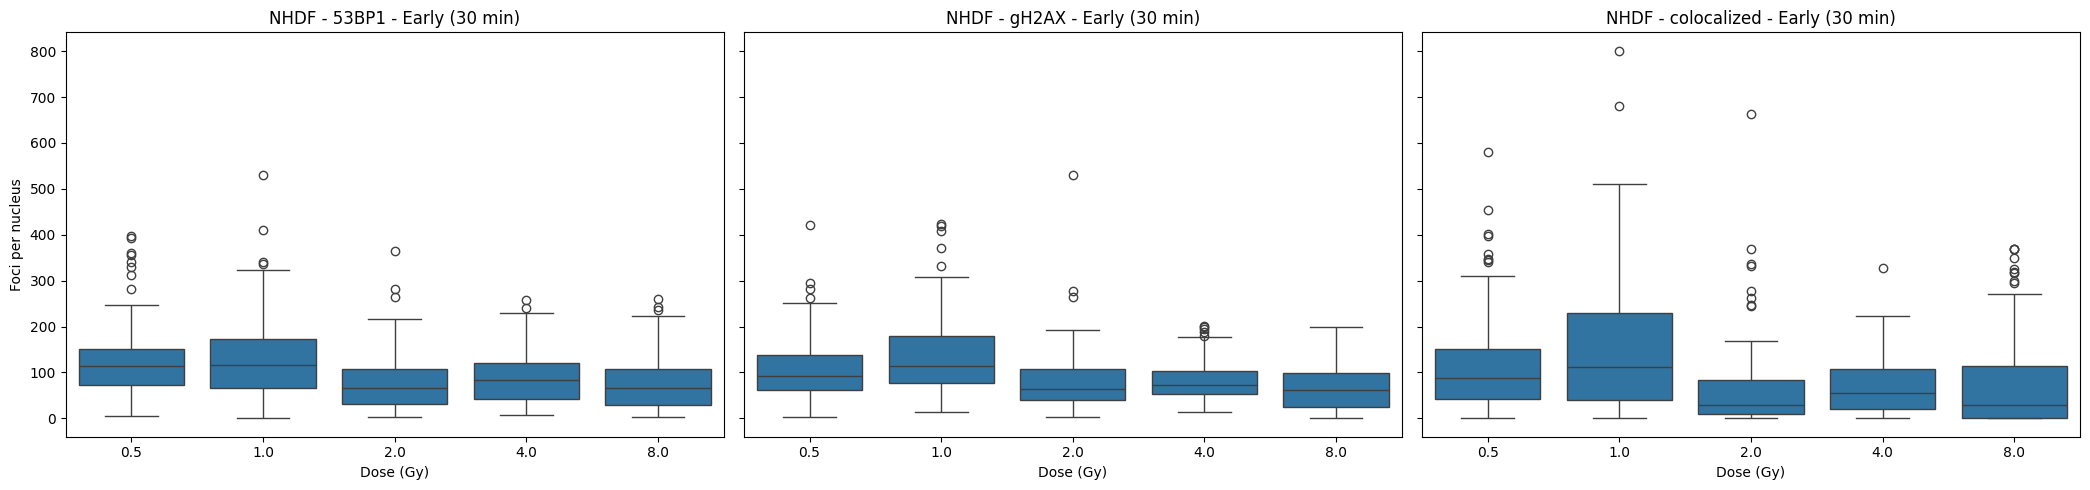


Cell line: NHDF | Timepoint: Late (8h)


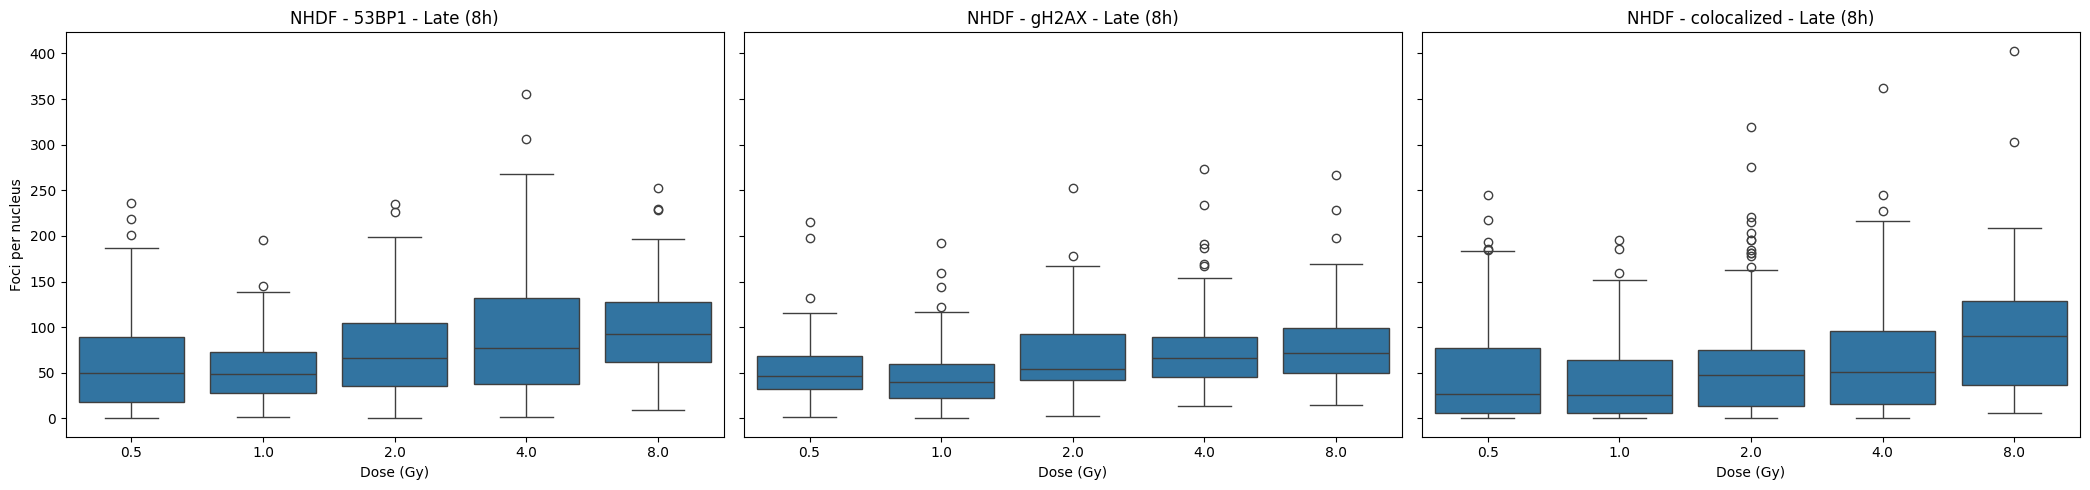


Cell line: U87 | Timepoint: Early (30 min)


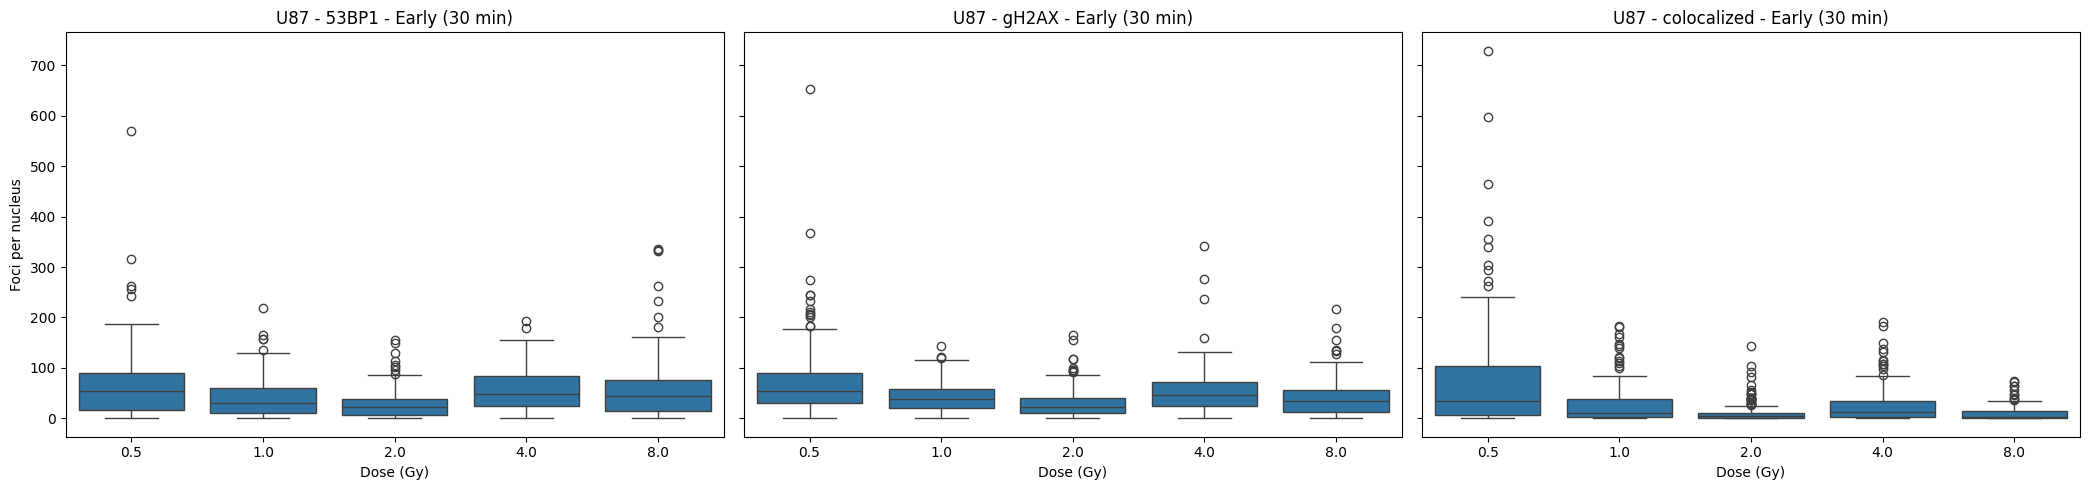


Cell line: U87 | Timepoint: Late (8h)


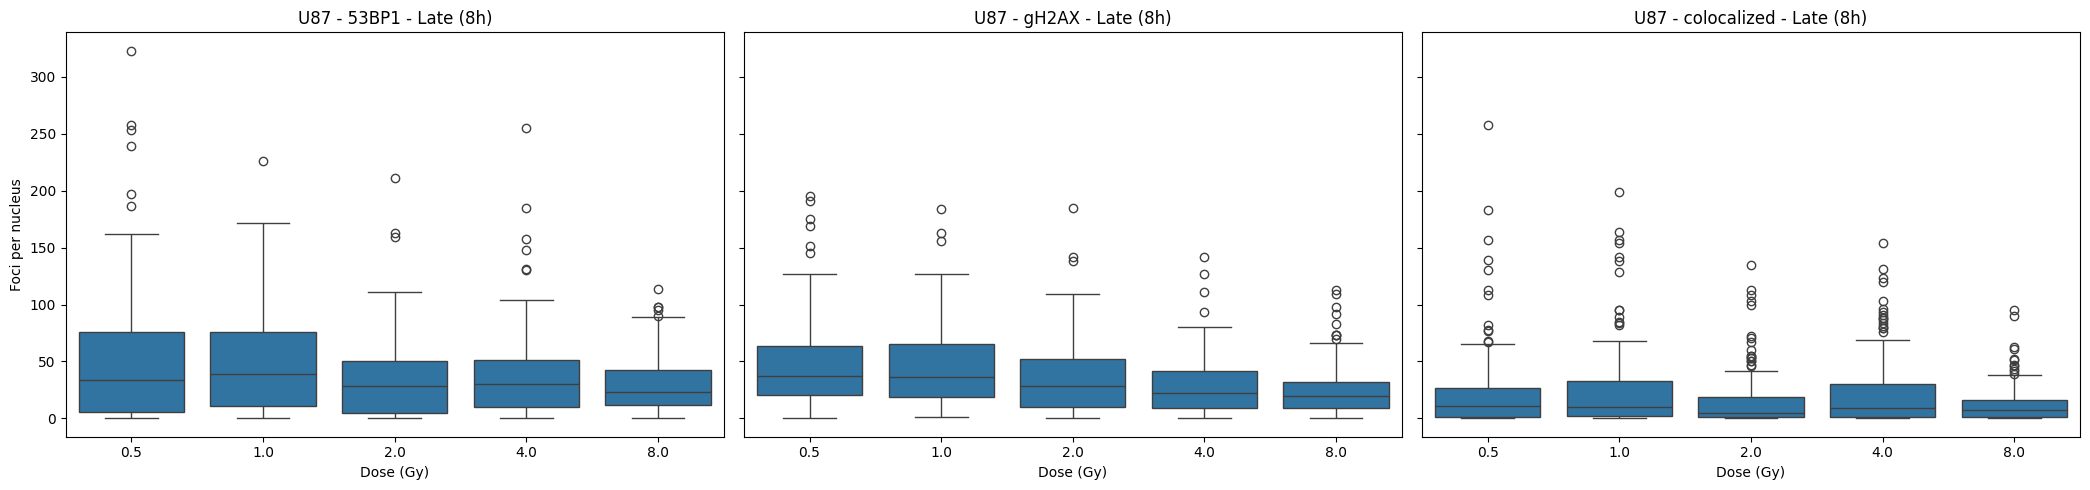

In [20]:


def plot_foci_vs_dose(input_df, cell_line, timepoint):
    df = input_df[(input_df["cell_line"] == cell_line) & (input_df["timepoint"] == timepoint)].copy()

    if df.empty:
        print(f"No data for cell line={cell_line}, timepoint={timepoint}")
        return

    dose_order = sorted(df["dose_gy"].dropna().unique())
    preferred_channel_order = ["53BP1", "gH2AX", "colocalized"]
    channel_order = [ch for ch in preferred_channel_order if ch in df["channel"].unique()]

    n_channels = len(channel_order)
    fig, axes = plt.subplots(1, n_channels, figsize=(7 * n_channels, 5), sharey=True)
    if n_channels == 1:
        axes = [axes]

    for c, ch in enumerate(channel_order):
        ax = axes[c]
        dsub = df[df["channel"] == ch]

        if dsub.empty:
            ax.set_title(f"{cell_line} - {ch} - {timepoint}")
            ax.set_xlabel("Dose (Gy)")
            ax.set_ylabel("Foci per nucleus")
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            continue

        sns.boxplot(
            data=dsub,
            x="dose_gy",
            y="n_foci",
            order=dose_order,
            ax=ax,
        )
        ax.set_title(f"{cell_line} - {ch} - {timepoint}")
        ax.set_xlabel("Dose (Gy)")
        ax.set_ylabel("Foci per nucleus")

    plt.tight_layout()
    plt.show()

# Iterate over Cartesian product of unique cell lines and unique timepoints
unique_cell_lines = sorted(nuclei_foci["cell_line"].dropna().unique())
unique_timepoints = sorted(nuclei_foci["timepoint"].dropna().unique())
print("Unique cell lines:", unique_cell_lines)
print("Unique timepoints:", unique_timepoints)

for selected_cell_line, tp in product(unique_cell_lines, unique_timepoints):
    print(f"\nCell line: {selected_cell_line} | Timepoint: {tp}")
    plot_foci_vs_dose(nuclei_foci, selected_cell_line, tp)